In [86]:
# CÀI ĐẶT THƯ VIỆN CẦN THIẾT
!pip install mlxtend

# IMPORT THƯ VIỆN
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import time


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
# ĐỌC DỮ LIỆU NHỊ PHÂN SAU TIỀN XỬ LÝ
basket_sets = pd.read_csv("..\cleaned_basket.csv", index_col=0)

# ÁP DỤNG THUẬT TOÁN APRIORI
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True, low_memory=True)

# HIỂN THỊ CÁC TẬP MỤC PHỔ BIẾN
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules[(rules['confidence'] >= 0.5) & (rules['lift'] >= 1.0)]

# Sắp xếp theo độ nâng giảm dần
rules = rules.sort_values(by='lift', ascending=False)

# Hiển thị top 10 luật kết hợp mạnh nhất
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\TGDD-ASUS\AppData\Local\Temp\ipykernel_15808\279029203.py:2: SyntaxWarning: invalid escape sequence '\c'
  basket_sets = pd.read_csv("..\cleaned_basket.csv", index_col=0)
c:\Users\TGDD-ASUS\Documents\HK251\DATA\BTL\venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                              itemsets
583  0.113160  (white hanging heart t-light holder)
249  0.086912             (jumbo bag red retrospot)
413  0.084690            (regency cakestand 3 tier)
37   0.078083       (assorted colour bird ornament)
340  0.077542                       (party bunting)
284  0.067271             (lunch bag red retrospot)
467  0.060484    (set of 3 cake tins pantry design)
276  0.059823             (lunch bag  black skull.)
334  0.056760      (paper chain kit 50's christmas)
307  0.056340      (natural slate heart chalkboard)
                               antecedents  \
148                    (herb marker thyme)   
149                 (herb marker rosemary)   
533              (regency tea plate green)   
532              (regency tea plate roses)   
510            (poppy's playhouse bedroom)   
511         (poppy's playhouse livingroom)   
554     (set of 3 wooden tree decorations)   
555  (set of 3 wooden stocking decoration)   
512           

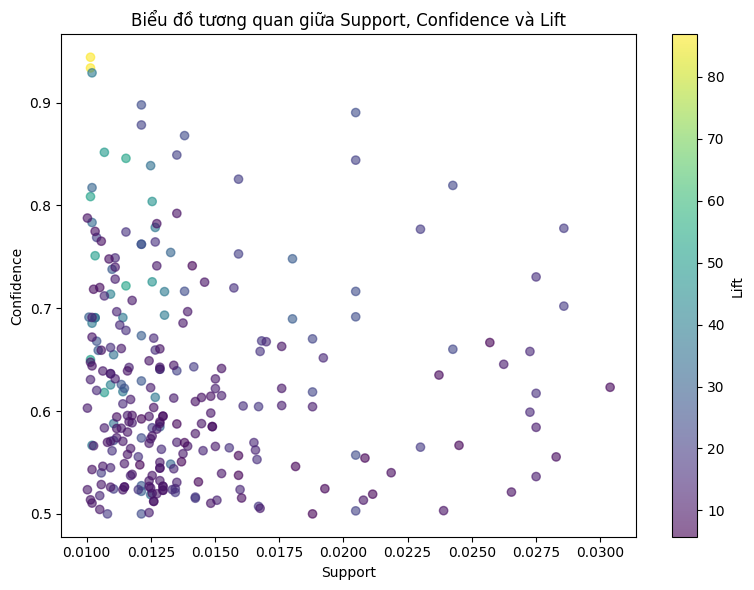

In [88]:

plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
plt.title('Biểu đồ tương quan giữa Support, Confidence và Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar(label='Lift')
plt.tight_layout()
plt.show()

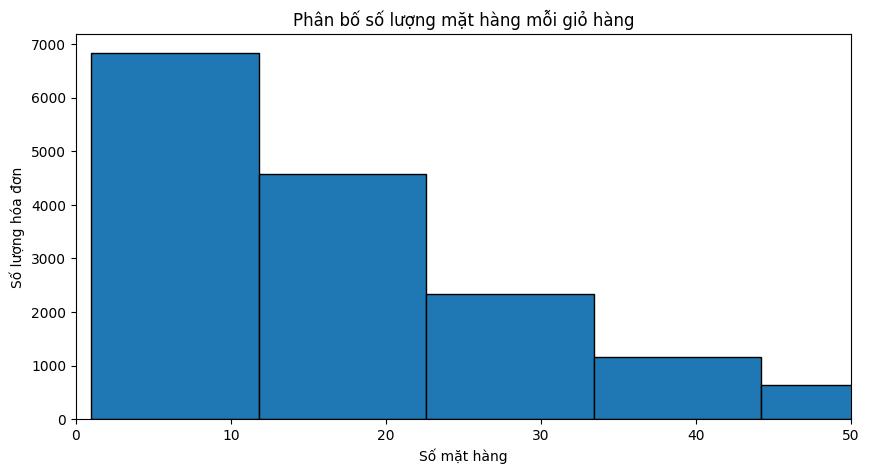

Giỏ hàng trung bình có: 20.68 mặt hàng
Giỏ hàng phổ biến nhất (median) có: 15.0 mặt hàng


In [89]:
basket_size = basket_sets.sum(axis=1)

# Trực quan hóa phân bố kích thước giỏ
plt.figure(figsize=(10, 5))
plt.hist(basket_size, bins=50, edgecolor='black')
plt.title('Phân bố số lượng mặt hàng mỗi giỏ hàng')
plt.xlabel('Số mặt hàng')
plt.ylabel('Số lượng hóa đơn')
plt.xlim(0, 50) # Giới hạn trục X để dễ nhìn hơn
plt.show()

print(f"Giỏ hàng trung bình có: {basket_size.mean():.2f} mặt hàng")
print(f"Giỏ hàng phổ biến nhất (median) có: {basket_size.median()} mặt hàng")

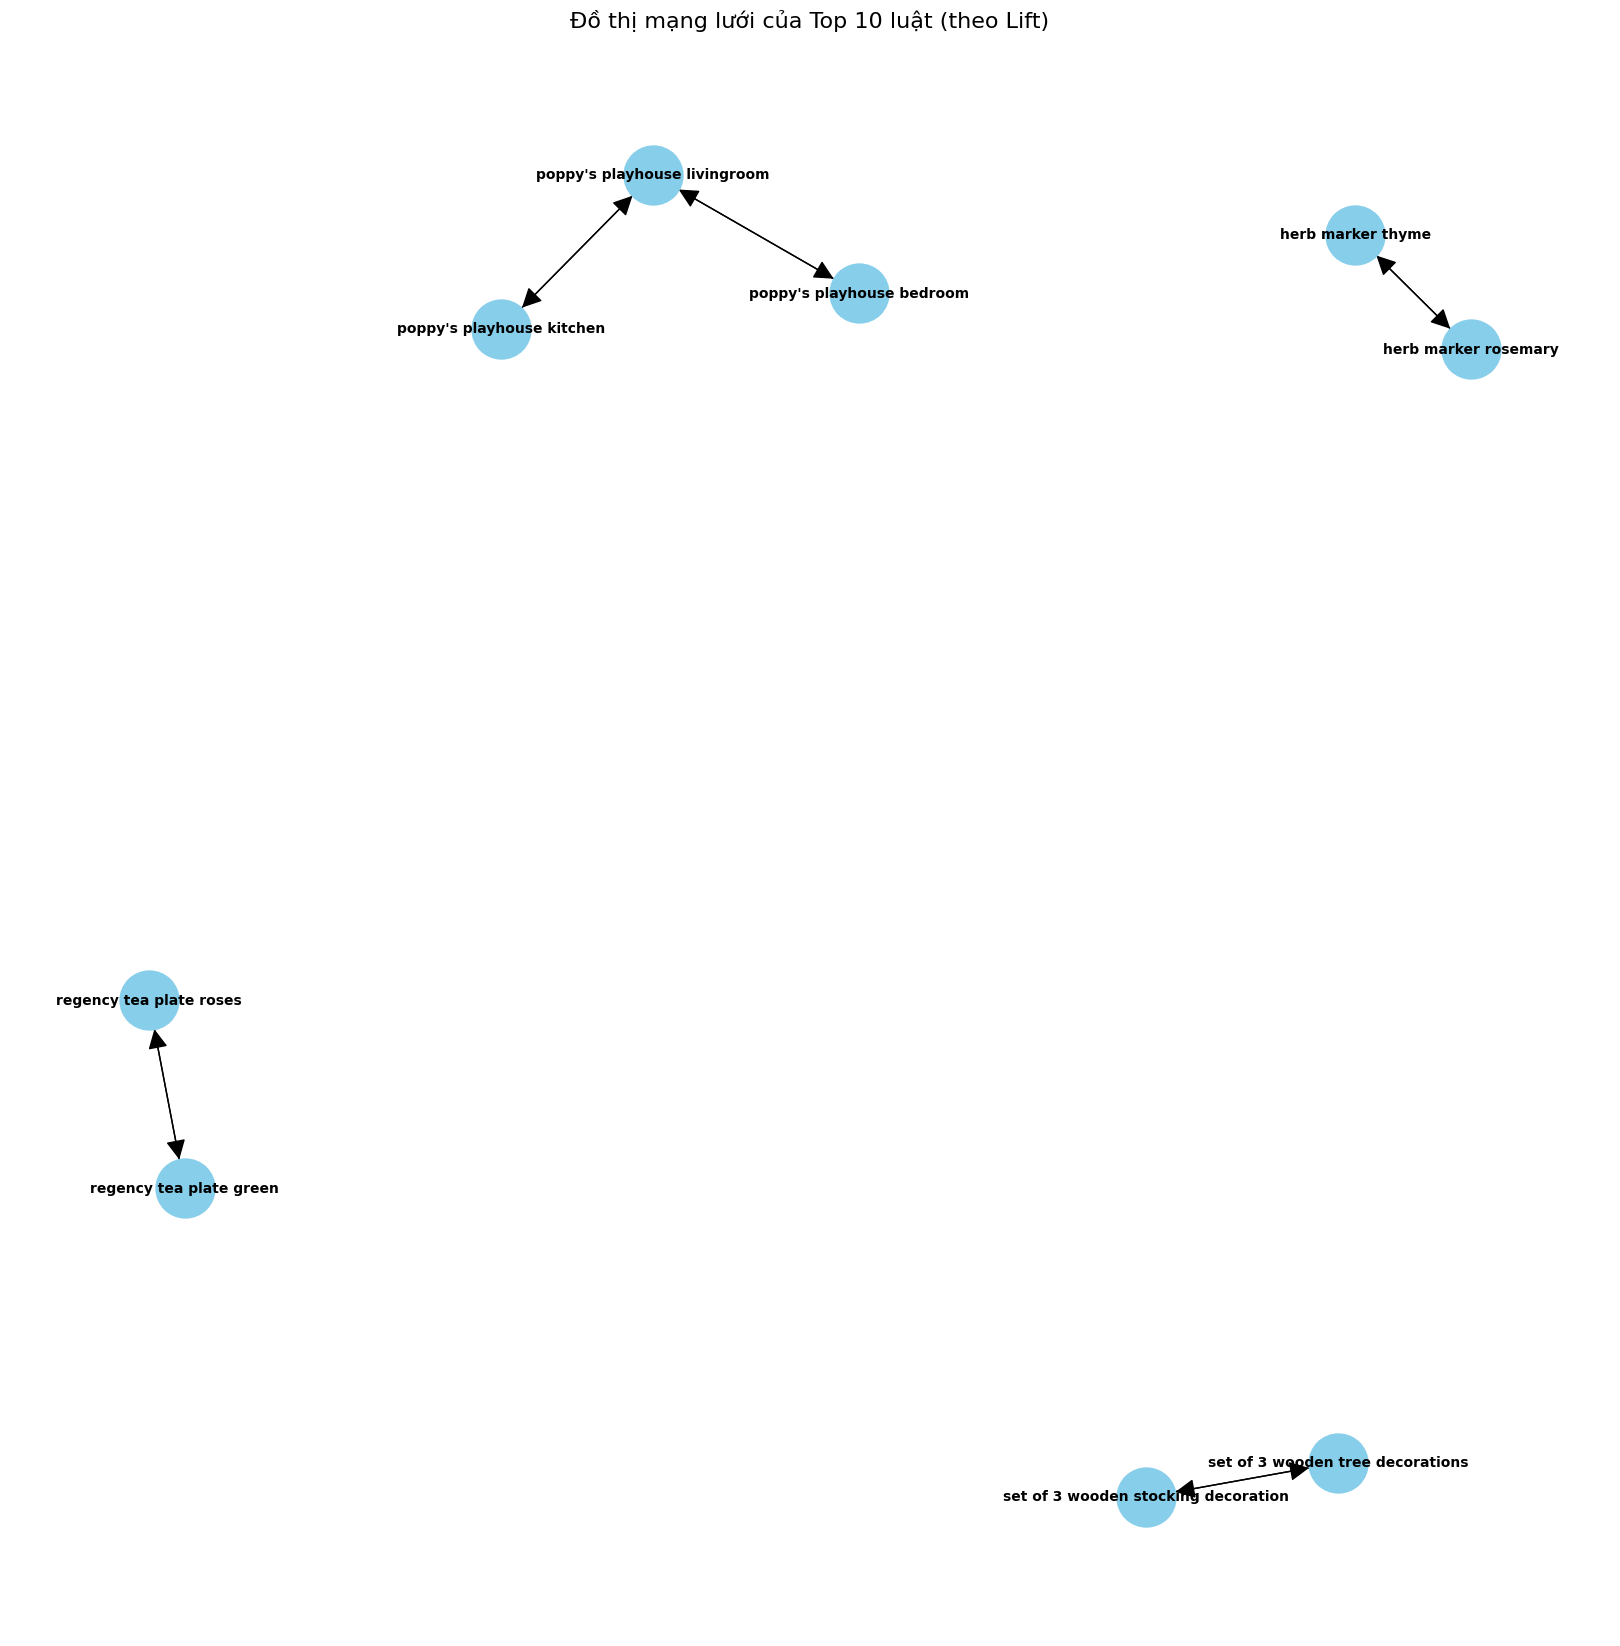

In [96]:
top_rules = rules.nlargest(10, 'lift')

# Chuyển đổi frozenset thành string để vẽ
ga = nx.DiGraph()
for _, row in top_rules.iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    ga.add_edge(antecedent, consequent, weight=row['lift'])

# Tăng kích thước tổng thể của đồ thị
plt.figure(figsize=(16, 16))

# Tăng 'k' để đẩy các nút ra xa nhau hơn
pos = nx.spring_layout(ga, k=4, seed=42, iterations=100) # Tăng k từ 0.5 lên 1.5

nx.draw(ga, pos, with_labels=True, 
        node_size=1800,
        node_color='skyblue',
        font_size=10,
        font_weight='bold', 
        arrowsize=30)

plt.title('Đồ thị mạng lưới của Top 10 luật (theo Lift)', size=16)
plt.show()

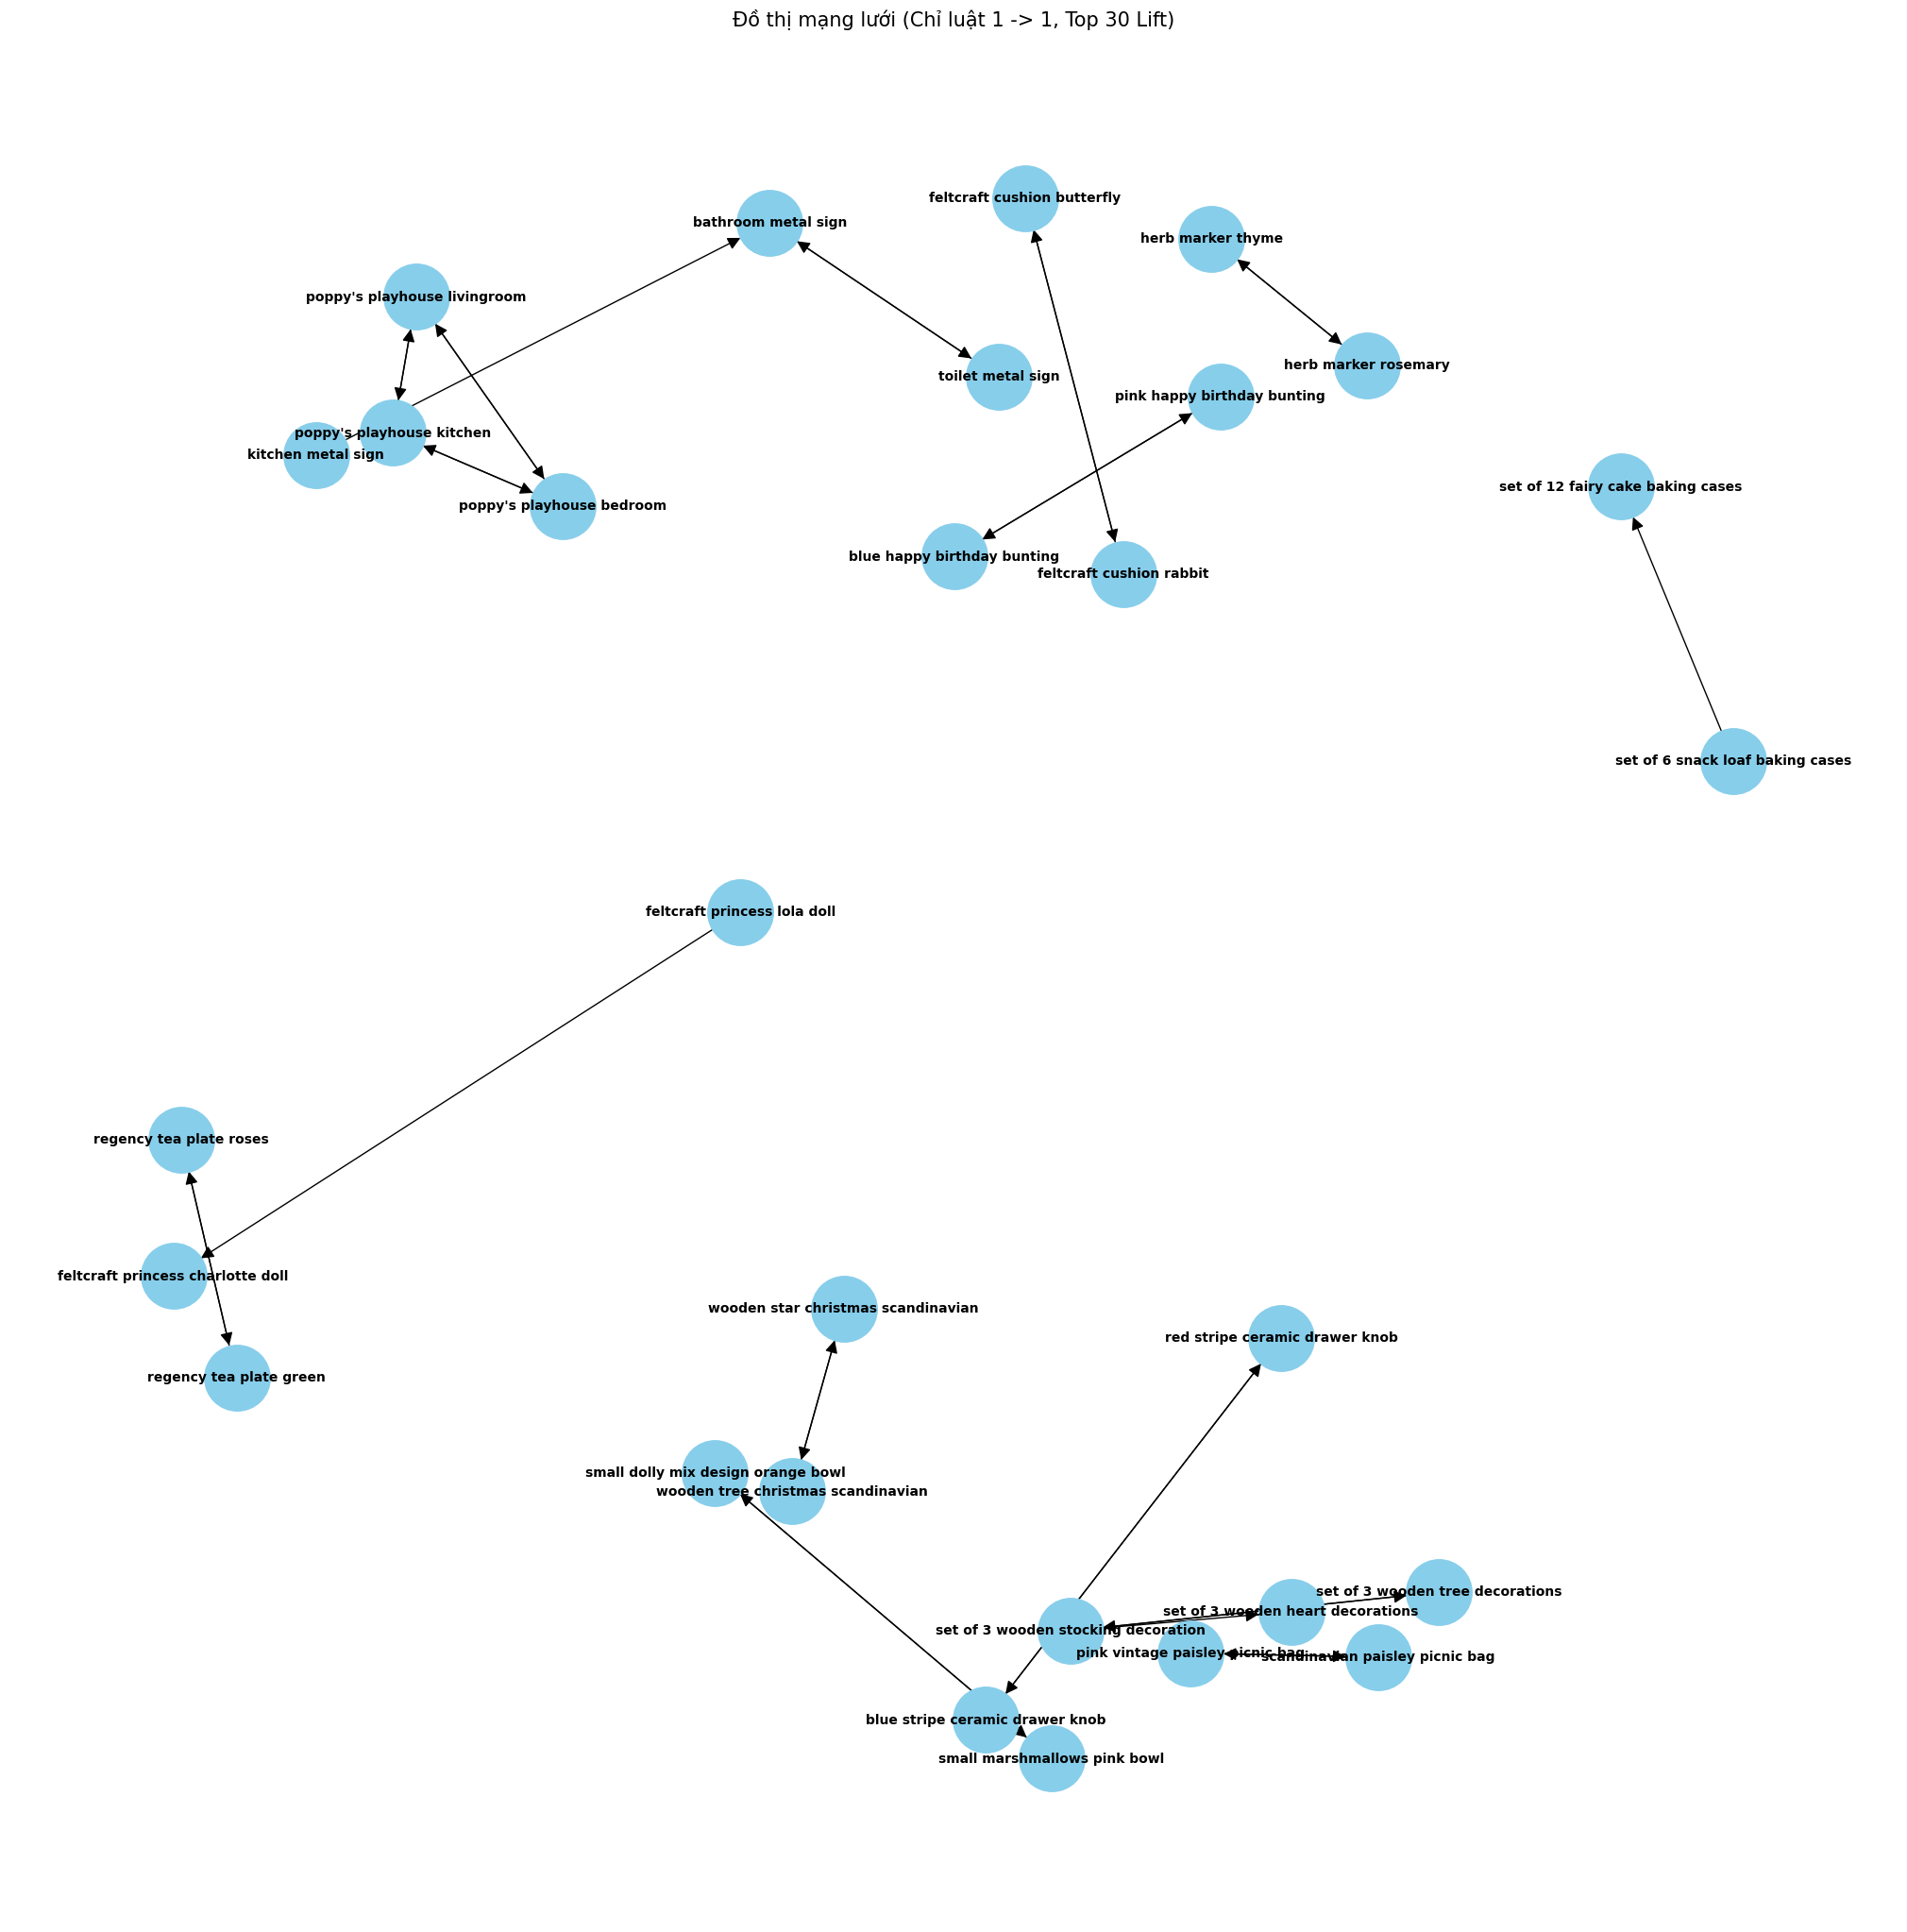

In [104]:
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

# Lọc các luật có dạng: (1 sản phẩm) -> (1 sản phẩm)
simple_rules = rules[
    (rules['antecedent_len'] == 1) & 
    (rules['consequent_len'] == 1) &
    (rules['lift'] > 5)
].nlargest(30, 'lift') # Lấy top 30 luật 1-1 mạnh nhất

# TẠO ĐỒ THỊ MỚI
ga_simple = nx.DiGraph()

for _, row in simple_rules.iterrows():
    antecedent = list(row['antecedents'])[0]
    consequent = list(row['consequents'])[0]
    ga_simple.add_node(antecedent)
    ga_simple.add_node(consequent)
    ga_simple.add_edge(antecedent, consequent, weight=row['lift'])

# VẼ ĐỒ THỊ ĐÃ TÁCH NÚT
plt.figure(figsize=(20, 20)) 
pos_simple = nx.spring_layout(ga_simple, k=4, seed=42, iterations=100) 
nx.draw(ga_simple, pos_simple, with_labels=True, 
        node_size=2500,
        node_color='skyblue',
        font_size=10, 
        font_weight='bold', 
        arrowsize=20)
            
plt.title('Đồ thị mạng lưới (Chỉ luật 1 -> 1, Top 30 Lift)', size=15)
plt.show()

Đã vẽ và lưu heatmap thành công vào file 'top_products_heatmap.png'


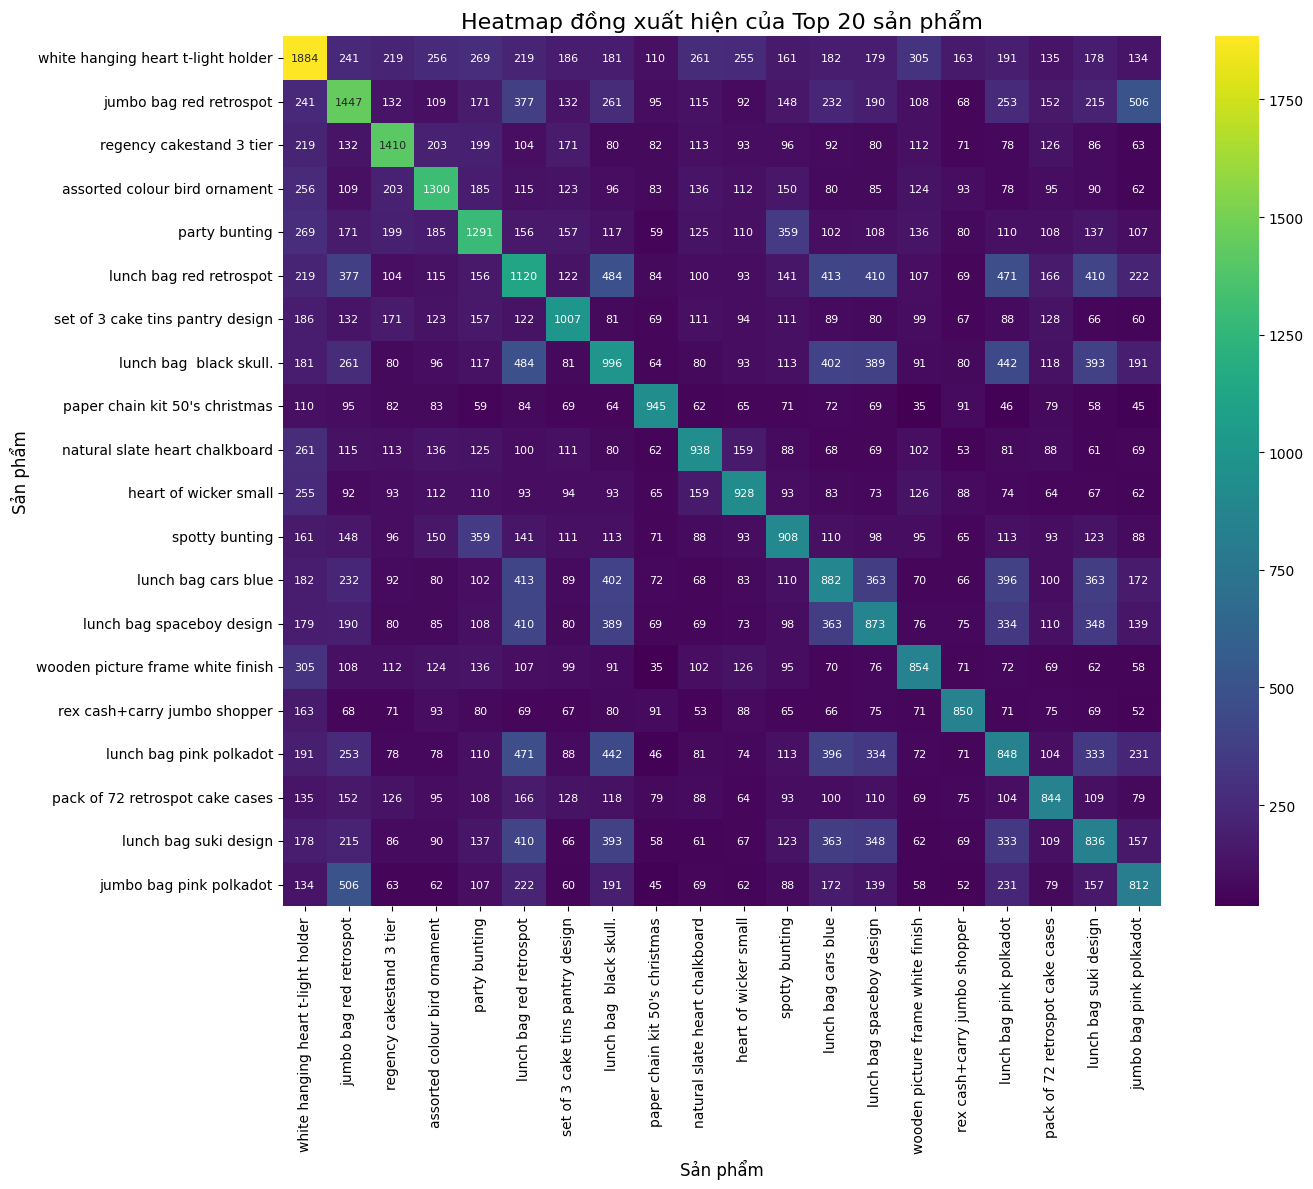

In [92]:
basket_sets_int = basket_sets.astype(int)

# Tính toán support của từng sản phẩm
item_support = basket_sets_int.sum(axis=0) / basket_sets_int.shape[0]

# Chọn Top 20 sản phẩm bán chạy nhất
topM = 20
top_products = item_support.sort_values(ascending=False).head(topM).index.tolist()

# --- Tạo ma trận con và ma trận đồng xuất hiện ---
sub_basket = basket_sets_int[top_products]
cooc_matrix = np.dot(sub_basket.T, sub_basket)
cooc_df = pd.DataFrame(cooc_matrix, index=top_products, columns=top_products)

# --- Vẽ Heatmap ---
plt.figure(figsize=(14, 12))
sns.heatmap(cooc_df, annot=True, fmt='d', cmap='viridis', annot_kws={"size": 8}) 
plt.title(f"Heatmap đồng xuất hiện của Top {topM} sản phẩm", size=16)
plt.xlabel("Sản phẩm", size=12)
plt.ylabel("Sản phẩm", size=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("top_products_heatmap.png")
print("Đã vẽ và lưu heatmap thành công vào file 'top_products_heatmap.png'")
plt.show()

In [93]:
# 3. XÂY DỰNG HÀM GỢI Ý

def recommend_from_basket(cart_items, rules_df, top_k=5):
    """
    Gợi ý sản phẩm dựa trên các mặt hàng có trong giỏ.
    cart_items: list các tên sản phẩm trong giỏ
    rules_df: DataFrame các luật đã lọc
    top_k: Số lượng gợi ý
    """
    cart_set = set(cart_items)
    recommendations = {}
    
    # Duyệt qua các luật
    for _, row in rules_df.iterrows():
        antecedent_set = set(row['antecedents'])
        
        # Nếu sản phẩm trong luật (antecedent) nằm trong giỏ hàng
        if antecedent_set.issubset(cart_set):
            # Lấy các sản phẩm gợi ý (consequents)
            for item in row['consequents']:
                # Nếu sản phẩm gợi ý chưa có trong giỏ
                if item not in cart_set:
                    # Dùng 'confidence' làm điểm số ban đầu
                    if item not in recommendations:
                        recommendations[item] = row['confidence']
                    else:
                        # Nếu 1 sản phẩm được gợi ý bởi nhiều luật, ưu tiên luật có confidence cao
                        if row['confidence'] > recommendations[item]:
                            recommendations[item] = row['confidence']
                            
    # Sắp xếp các gợi ý theo 'confidence' giảm dần
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    # Trả về top_k gợi ý hàng đầu
    return sorted_recommendations[:top_k]

# ----- VÍ DỤ SỬ DỤNG -----

# TH1: Khách hàng thêm "Tách trà hồng" vào giỏ
cart_1 = ['pink regency teacup and saucer']
suggestions_1 = recommend_from_basket(cart_1, rules)
print(f"Gợi ý cho giỏ hàng {cart_1}: \n {suggestions_1}\n")

# TH2: Khách hàng thêm cả "Tách trà hồng" VÀ "Tách trà hoa hồng"
cart_2 = ['pink regency teacup and saucer', 'roses regency teacup and saucer']
suggestions_2 = recommend_from_basket(cart_2, rules)
print(f"Gợi ý cho giỏ hàng {cart_2}: \n {suggestions_2}\n")

Gợi ý cho giỏ hàng ['pink regency teacup and saucer']: 
 [('green regency teacup and saucer', 0.8194726166328601), ('roses regency teacup and saucer', 0.7768762677484787), ('regency cakestand 3 tier', 0.5375253549695741)]

Gợi ý cho giỏ hàng ['pink regency teacup and saucer', 'roses regency teacup and saucer']: 
 [('green regency teacup and saucer', 0.8903394255874674), ('regency cakestand 3 tier', 0.5874673629242819)]



In [94]:
# 4. XUẤT FILE CSV
# Cần chuyển đổi frozenset thành text trước khi lưu
rules_export = rules.copy()
rules_export['antecedents'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_export['consequents'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))

# Lưu file
rules_export.to_csv(r"..\association_rules_final.csv", index=False, encoding='utf-8-sig')
print("Đã xuất file 'association_rules_final.csv' thành công!")

Đã xuất file 'association_rules_final.csv' thành công!
